## Comological analysis pipeline script

In [1]:
import os
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import sys
import glob
import numpy as np
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
from getdist import plots
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 12
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# from mockfactory import Catalog
from cosmoprimo.fiducial import DESI, AbacusSummit
from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate, ShapeFitPowerSpectrumTemplate, StandardPowerSpectrumTemplate
from desilike.theories.galaxy_clustering import FOLPSTracerPowerSpectrumMultipoles, LPTVelocileptorsTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.emulators import EmulatedCalculator, Emulator, TaylorEmulatorEngine
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.profilers import MinuitProfiler
from desilike.samplers.emcee import EmceeSampler
from desilike.samples import plotting, Chain
from desilike import setup_logging
setup_logging()  # for logging messages

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
sys.path.append('/global/homes/s/shengyu/project_rc/main/Y3/')
from helper import REDSHIFT_VSMEAR, REDSHIFT_CUBICBOX, GET_RECON_BIAS
from helper import REDSHIFT_LSS_VSMEAR, REDSHIFT_LSS_CUBICBOX, PLANCK_COSMOLOGY, COLOR_TRACERS
from fitting_tools import get_observable_likelihood, get_template, get_theory, load_bins, load_cov, load_data_fns
%load_ext autoreload
%autoreload 2

Z_VSMEAR = REDSHIFT_VSMEAR
Z_CUBIC = REDSHIFT_CUBICBOX
result_dir = '/pscratch/sd/s/shengyu/galaxies/results/cubic'

## Load the data

In [3]:
# test the load_data_fns function
corr_type = 'pk'
bins_type = 'y3_sys'
(kmin, kmax, kbin, lenk) = load_bins(corr_type, bins_type)
klim = {ell*2: (kmin,kmax,kbin) for ell in range(2)}

tracer = 'LRG'
sys_model = 'standard'
(zmin, zmax) = Z_VSMEAR[tracer][0]
z_eff = Z_CUBIC[tracer][0]
data_args = {"tracer": tracer, "z_eff": z_eff, "zmin": zmin, "zmax": zmax, "sys_model": sys_model, "grid_cosmo": "000"}
load_data_fns(data_args, corr_type = corr_type, data_type='cubic_sys')

/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0.6/AbacusSummit_base_c000_ph*/mpspk


['/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0.6/AbacusSummit_base_c000_ph000/mpspk/pkpoles_LRG_z0.4-0.6_standard.npy',
 '/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0.6/AbacusSummit_base_c000_ph001/mpspk/pkpoles_LRG_z0.4-0.6_standard.npy',
 '/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0.6/AbacusSummit_base_c000_ph002/mpspk/pkpoles_LRG_z0.4-0.6_standard.npy',
 '/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0.6/AbacusSummit_base_c000_ph003/mpspk/pkpoles_LRG_z0.4-0.6_standard.npy',
 '/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0.6/AbacusSummit_base_c000_ph004/mpspk/pkpoles_LRG_z0.4-0.6_standard.npy',
 '/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0.6/AbacusSummit_base_c000_ph005/mpspk/pkpoles_LRG_z0.4-0.6_standar

## Load the covariance

In [4]:
# test the load_cov function
load_cov(data_args, corr_type='pk', cov_type='EZcov_fn', bins_type=bins_type)

array([[ 2.18822239e+07,  5.01614221e+05,  1.00473802e+05, ...,
        -1.39468456e+04,  9.81066601e+03,  1.69373886e+04],
       [ 5.01614221e+05,  1.14494066e+07, -8.44041565e+03, ...,
         2.23996841e+04,  1.62946875e+04,  6.43855339e+03],
       [ 1.00473802e+05, -8.44041565e+03,  6.71651260e+06, ...,
         8.88697154e+03,  1.24358529e+04,  2.94828351e+02],
       ...,
       [-1.39468456e+04,  2.23996841e+04,  8.88697154e+03, ...,
         2.19337627e+04,  1.14740747e+03,  3.52887663e+02],
       [ 9.81066601e+03,  1.62946875e+04,  1.24358529e+04, ...,
         1.14740747e+03,  1.82568588e+04,  6.47705829e+02],
       [ 1.69373886e+04,  6.43855339e+03,  2.94828351e+02, ...,
         3.52887663e+02,  6.47705829e+02,  1.61581857e+04]])

## Template and theory model

In [5]:
fit = 'FM' # FM: Full-Modeling, SF: Shape-Fit, BAO: BAO fit
cosmology = 'LCDM'
catalogue = 'cubic'
theory_model = 'folps' # vel, folps, required for full-shape
task = f'{fit}fit_{cosmology}_{catalogue}_{theory_model}'
template = get_template(task)
theory = get_theory(task, template, emulator_fn=None)

## Observable and Likelihood 

/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0.6/AbacusSummit_base_c000_ph*/mpspk
[000011.70] [0/1] 10-27 02:03  TracerPowerSpectrumMultipolesObservable INFO     Loading 25 files [/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0.6/AbacusSummit_base_c000_ph000/mpspk/pkpoles_LRG_z0.4-0.6_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0.6/AbacusSummit_base_c000_ph005/mpspk/pkpoles_LRG_z0.4-0.6_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0.6/AbacusSummit_base_c000_ph010/mpspk/pkpoles_LRG_z0.4-0.6_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0.6/AbacusSummit_base_c000_ph015/mpspk/pkpoles_LRG_z0.4-0.6_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/LRG/obs_z0.4-0.6

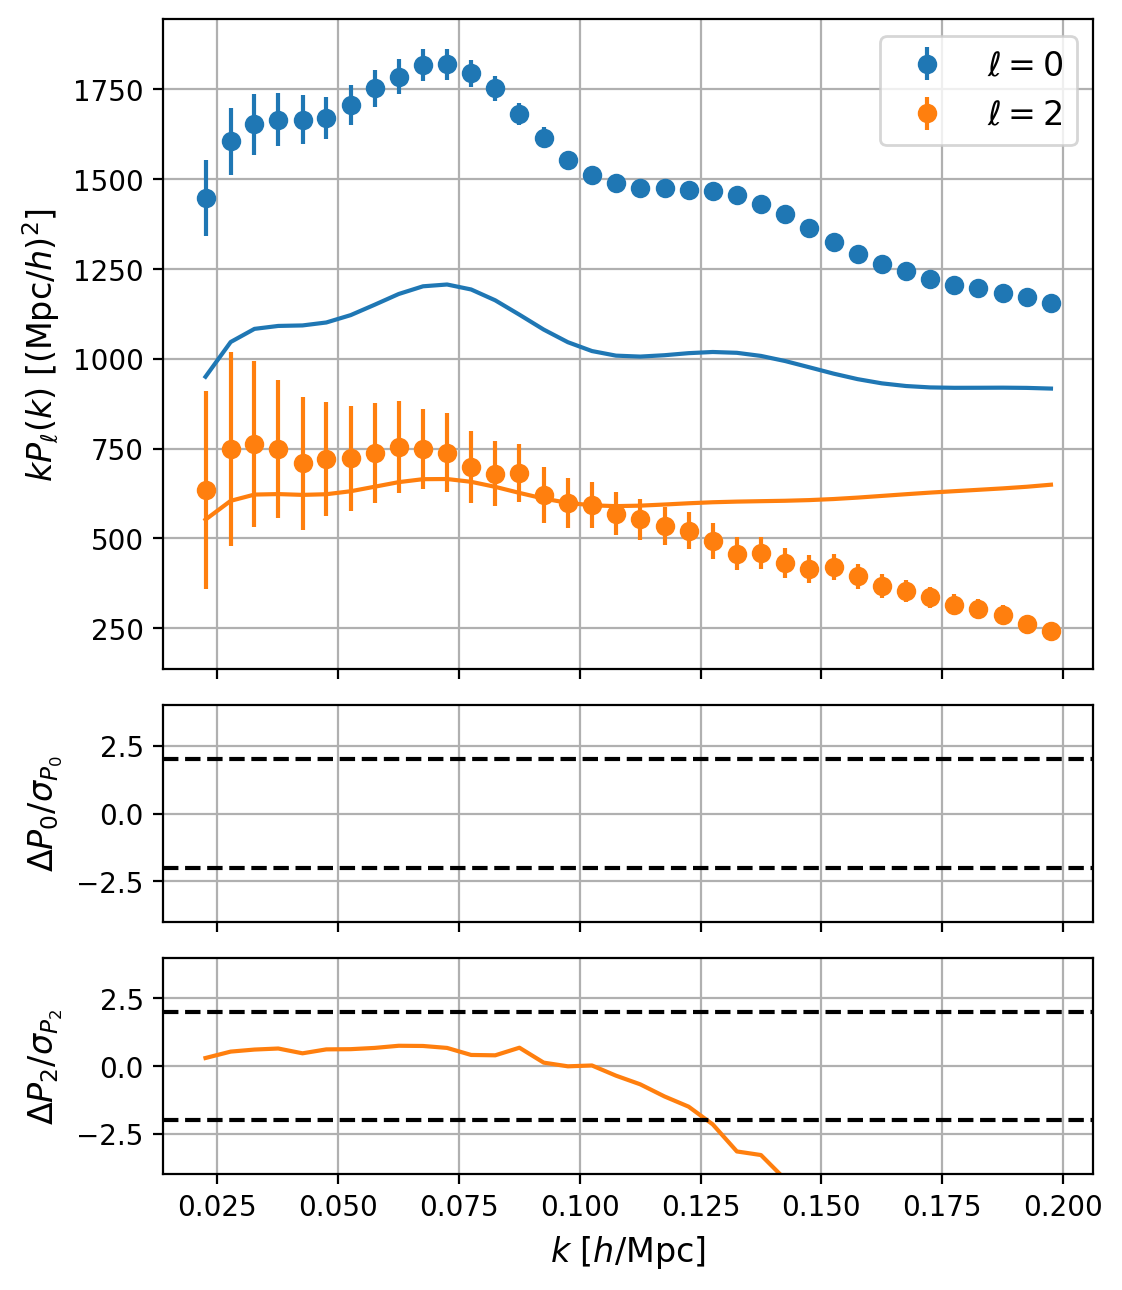

In [ ]:
data_type = 'cubic_sys' # cubic mocks from the AbacusHOD
cov_type = 'EZcov_fn' # EZcov_fn, EZmock
fit_args = {"corr_type": corr_type, "bins_type": bins_type, "data_type": data_type, "cov_type": cov_type}
# fit_args = {"corr_type": corr_type, "bins_type": bins_type, "data_type": data_type, "cov_type": cov_type, "emulator_fn":emulator_fn}
(likelihood, observable, theory) = get_observable_likelihood(task, data_args, fit_args)
fig = observable.plot()

## Parameters prior

In [7]:
for param in likelihood.varied_params:
    print(param, param.prior)

h uniform[0.2, 1.0]({})
omega_cdm uniform[0.01, 0.99]({})
omega_b norm({'loc': 0.02218, 'scale': 0.00055})
logA uniform[2.0, 4.0]({})
n_s norm({'loc': 0.9649, 'scale': 0.042})
b1 uniform[0.0, 10.0]({})
b2 uniform[-50.0, 50.0]({})
bs uniform({})
alpha0 uniform({})
alpha2 uniform({})
sn0 uniform({})
sn2 uniform({})


## Train emulator

In [8]:
emulator = Emulator(theory.pt, engine=TaylorEmulatorEngine(order=3, method='finite')) # Taylor expansion, up to a given order
emulator.set_samples() # evaluate the theory derivatives (with jax auto-differentiation if possible, else finite differentiation)
emulator.fit()

[000162.18] [0/1] 10-27 02:05  Emulator                  INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA', 'n_s'].
[000162.18] [0/1] 10-27 02:05  Emulator                  INFO     Found varying ['sigma8', 'fsigma8', 'kap', 'muap', 'table', 'table_now', 'sigma2t', 'f0', 'jac'] and fixed ['k', 'z', 'ells', 'wmu'] outputs.


/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/desilike/base.py:445: UserWarning: Derived parameter sigma8 of <desilike.theories.galaxy_clustering.full_shape.FOLPSPowerSpectrumMultipoles object at 0x7f5cbb7837c0> is already derived in <desilike.theories.galaxy_clustering.power_template.DirectPowerSpectrumTemplate object at 0x7f5cbb7daa90>.
  if self.mpicomm.rank == 0: warnings.warn(msg)


[000163.26] [0/1] 10-27 02:05  Differentiation           INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA', 'n_s'].
[000167.51] [0/1] 10-27 02:05  Differentiation           INFO     h grid is [0.6136 0.6436 0.6736 0.7036 0.7336].
[000167.51] [0/1] 10-27 02:05  Differentiation           INFO     omega_cdm grid is [0.1  0.11 0.12 0.13 0.14].
[000167.51] [0/1] 10-27 02:05  Differentiation           INFO     omega_b grid is [0.01937 0.02087 0.02237 0.02387 0.02537].
[000167.51] [0/1] 10-27 02:05  Differentiation           INFO     logA grid is [2.89639426 2.96639426 3.03639426 3.10639426 3.17639426].
[000167.51] [0/1] 10-27 02:05  Differentiation           INFO     n_s grid is [0.9449 0.9549 0.9649 0.9749 0.9849].
[000167.52] [0/1] 10-27 02:05  Differentiation           INFO     Differentiation will evaluate 141 points.
[000315.67] [0/1] 10-27 02:08  Emulator                  INFO     Fitting sigma8.
[000315.72] [0/1] 10-27 02:08  Emulator                  INFO     Fitting f

## Iminuit fit

In [9]:
theory_el = theory(pt=emulator)
likelihood_el = ObservablesGaussianLikelihood(observables=observable, theory=theory_el)
profiler = MinuitProfiler(likelihood_el, seed=42)
profiles = profiler.maximize()
print(profiles.to_stats(tablefmt='pretty'))
print(-2*likelihood_el(**profiles.bestfit.choice(input=True)))
fig = observable.plot()

PipelineError: input parameter pt is not one of parameters: ParameterCollection(['h', 'omega_cdm', 'omega_b', 'logA', 'n_s', 'tau_reio', 'm_ncdm', 'N_eff', 'w0_fld', 'wa_fld', 'Omega_k', 'sigma8', 'b1', 'b2', 'bs', 'b3', 'alpha0', 'alpha2', 'alpha4', 'ct', 'sn0', 'sn2'])

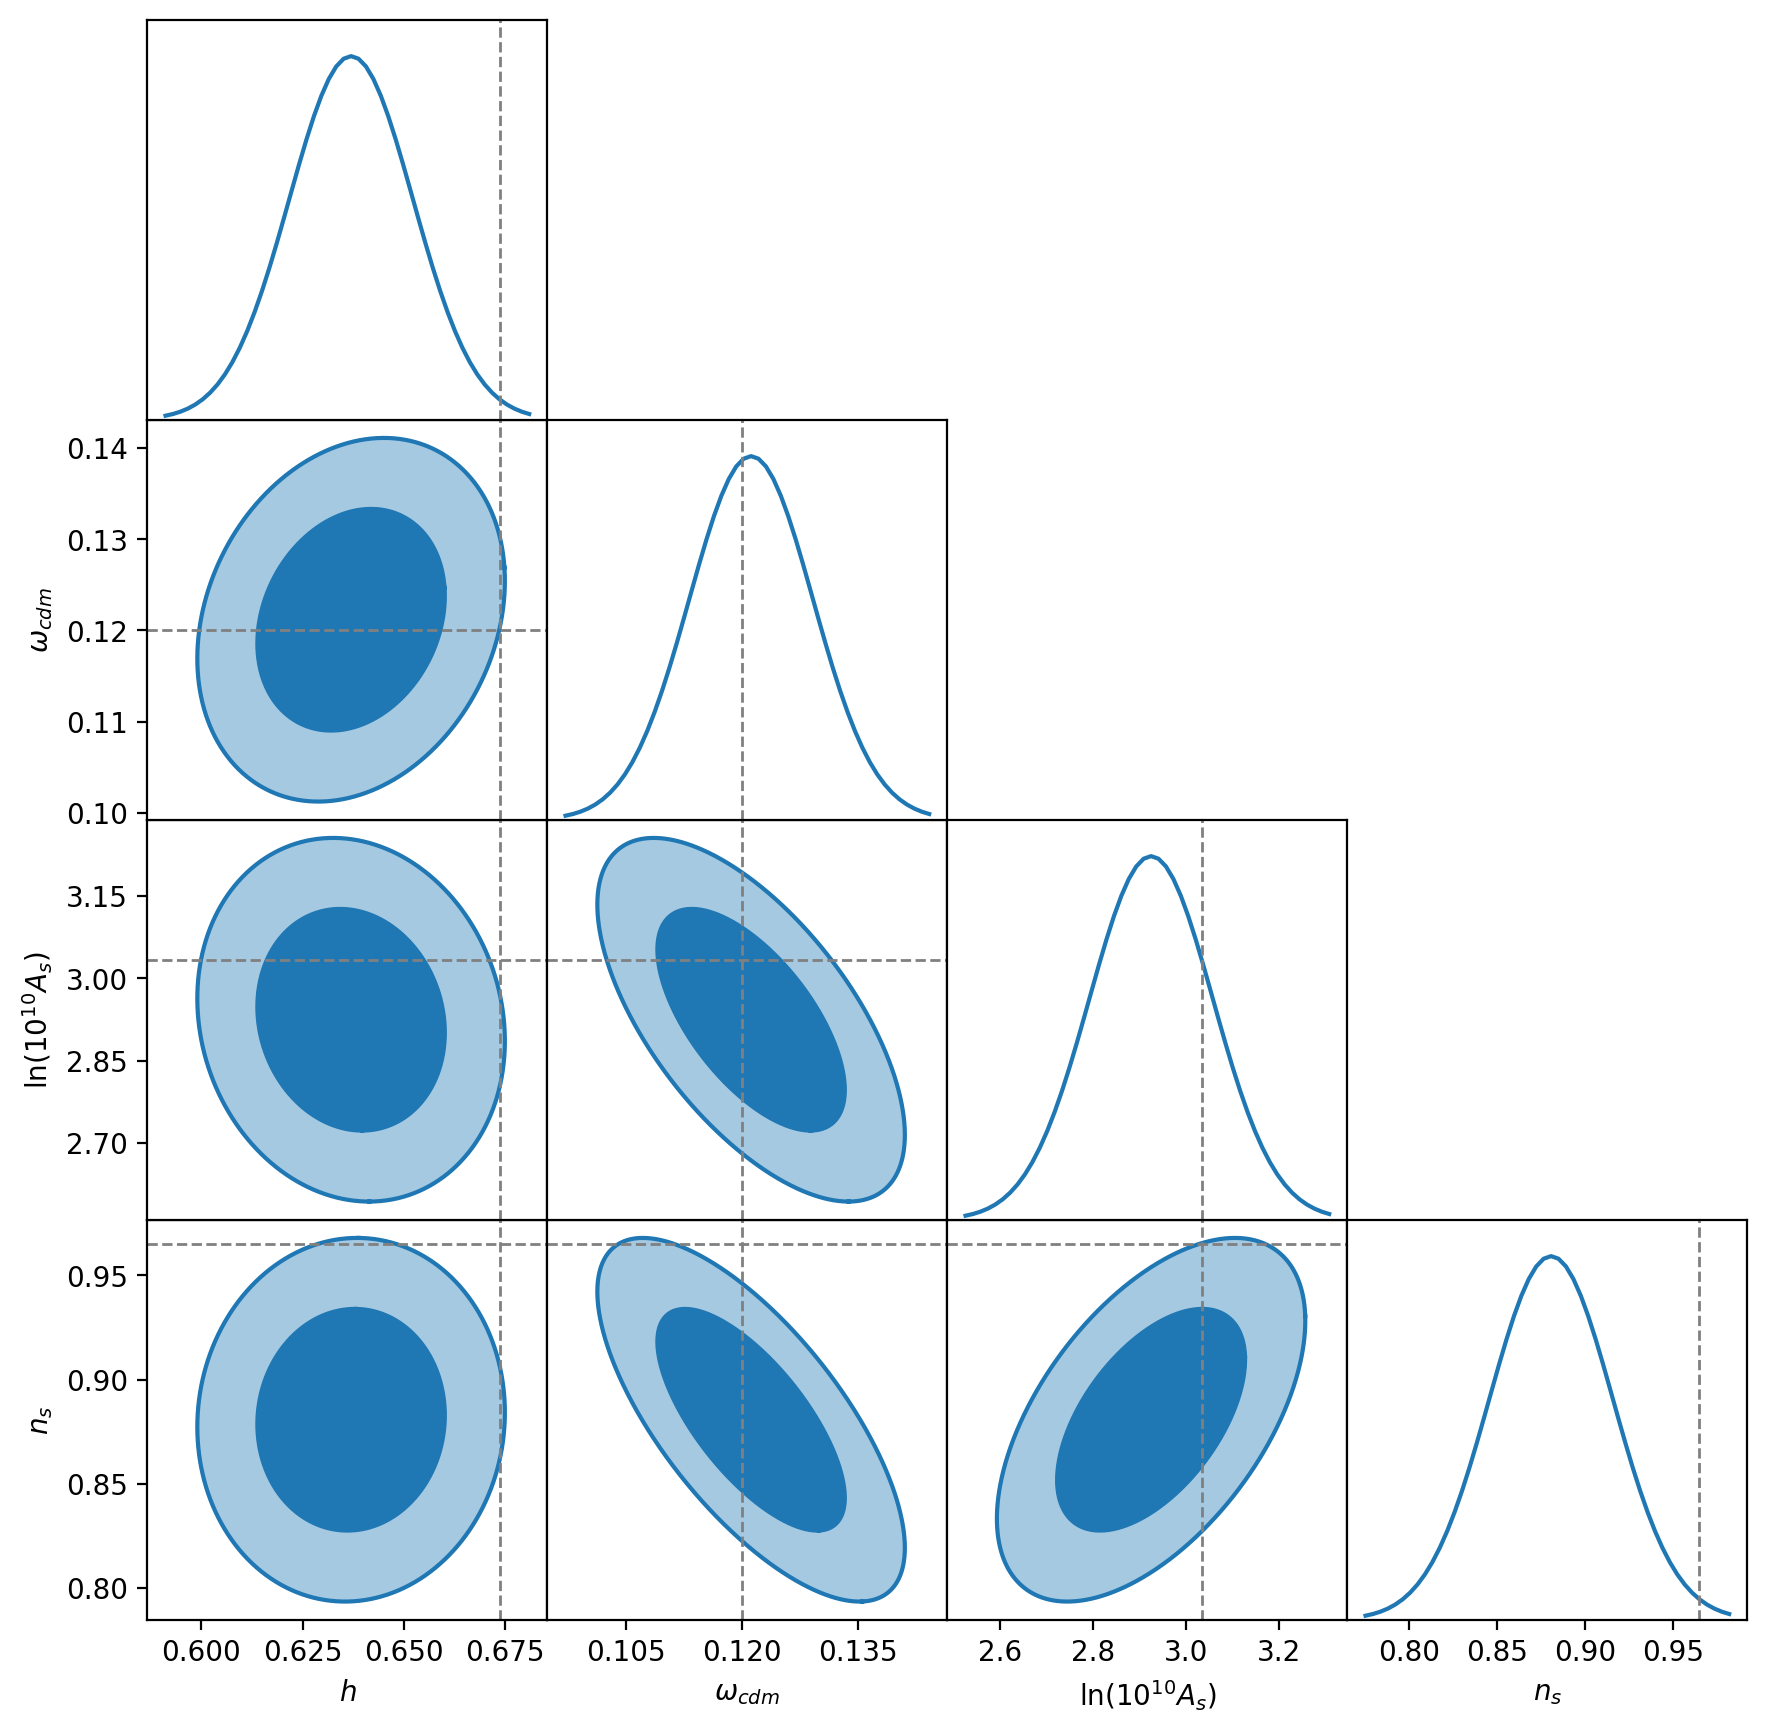

In [ ]:
def set_true_values(fit, params):
    if fit == 'SF':
        return [1,1,0,1]
    if fit == 'FM':
        return [PLANCK_COSMOLOGY[param] for param in params if param in PLANCK_COSMOLOGY]
# plot the posterior distribution
if 'FM' in task:
    params = ['h', 'omega_cdm', 'logA','n_s']
    # params = ['h', 'omega_cdm', 'logA']
    nwalkers = 64  # len(likelihood.varied_parmas)*4
    true_values = [PLANCK_COSMOLOGY[param] for param in params]
elif 'SF' in task:
    params = ['qiso', 'qap', 'dm', 'df']
    nwalkers = 64 # len(likelihood.varied_parmas)*4
    true_values = [1, 1, 0, 1]
from desilike.samples import plotting
fig = plotting.plot_triangle_contours(profiles, params=params, filled=True, truths=set_true_values(fit, params))

## MCMC sampling

In [41]:
# MCMC sampling
nwalkers = 64
iterations = 20001 # save every 300 iterations
sampler = EmceeSampler(likelihood_el, seed=42, nwalkers=nwalkers, save_fn = './test/chain.npy')
sampler.run(check={'max_eigen_gr': 0.05}, max_iterations = iterations) # save every 300 iterations

[000094.24] [0/1] 04-03 08:07  EmceeSampler              INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA', 'n_s', 'b1p', 'b2p', 'bsp', 'alpha0p', 'alpha2p', 'sn0p', 'sn2p'].


[000094.37] [0/1] 04-03 08:07  EmceeSampler              INFO     Successfully vmap input likelihood.
[000095.00] [0/1] 04-03 08:07  EmceeSampler              INFO     Successfully jit input likelihood.
[000100.69] [0/1] 04-03 08:07  Chain                     INFO     Saving ./test/chain.npy.
[000100.73] [0/1] 04-03 08:07  EmceeSampler              INFO     Diagnostics:
[000100.77] [0/1] 04-03 08:07  Diagnostics               INFO     - max eigen Gelman-Rubin - 1 is 3.86; not < 0.05.
[000100.81] [0/1] 04-03 08:07  Diagnostics               INFO     - max diag Gelman-Rubin - 1 is 0.516.
[000100.95] [0/1] 04-03 08:07  Diagnostics               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.807.
[000100.98] [0/1] 04-03 08:07  Diagnostics               INFO     - max Geweke is 0.579.
[000100.98] [0/1] 04-03 08:07  Diagnostics               INFO     - Geweke p-value is 8.13e-08.
[000101.25] [0/1] 04-03 08:07  Diagnostics               INFO     - effective sample size = (150 iterati

[Chain(shape=(20001, 64), params=ParameterCollection(['h', 'omega_cdm', 'omega_b', 'logA', 'n_s', 'b1p', 'b2p', 'bsp', 'alpha0p', 'alpha2p', 'sn0p', 'sn2p', 'logposterior', 'tau_reio', 'm_ncdm', 'N_eff', 'w0_fld', 'wa_fld', 'Omega_k', 'b3p', 'alpha4p', 'alpha6p', 'sn4p', 'sigma8', 'loglikelihood', 'logprior']))]

[000530.70] [0/1] 04-03 08:14  Chain                     INFO     Loading ./test/chain.npy.


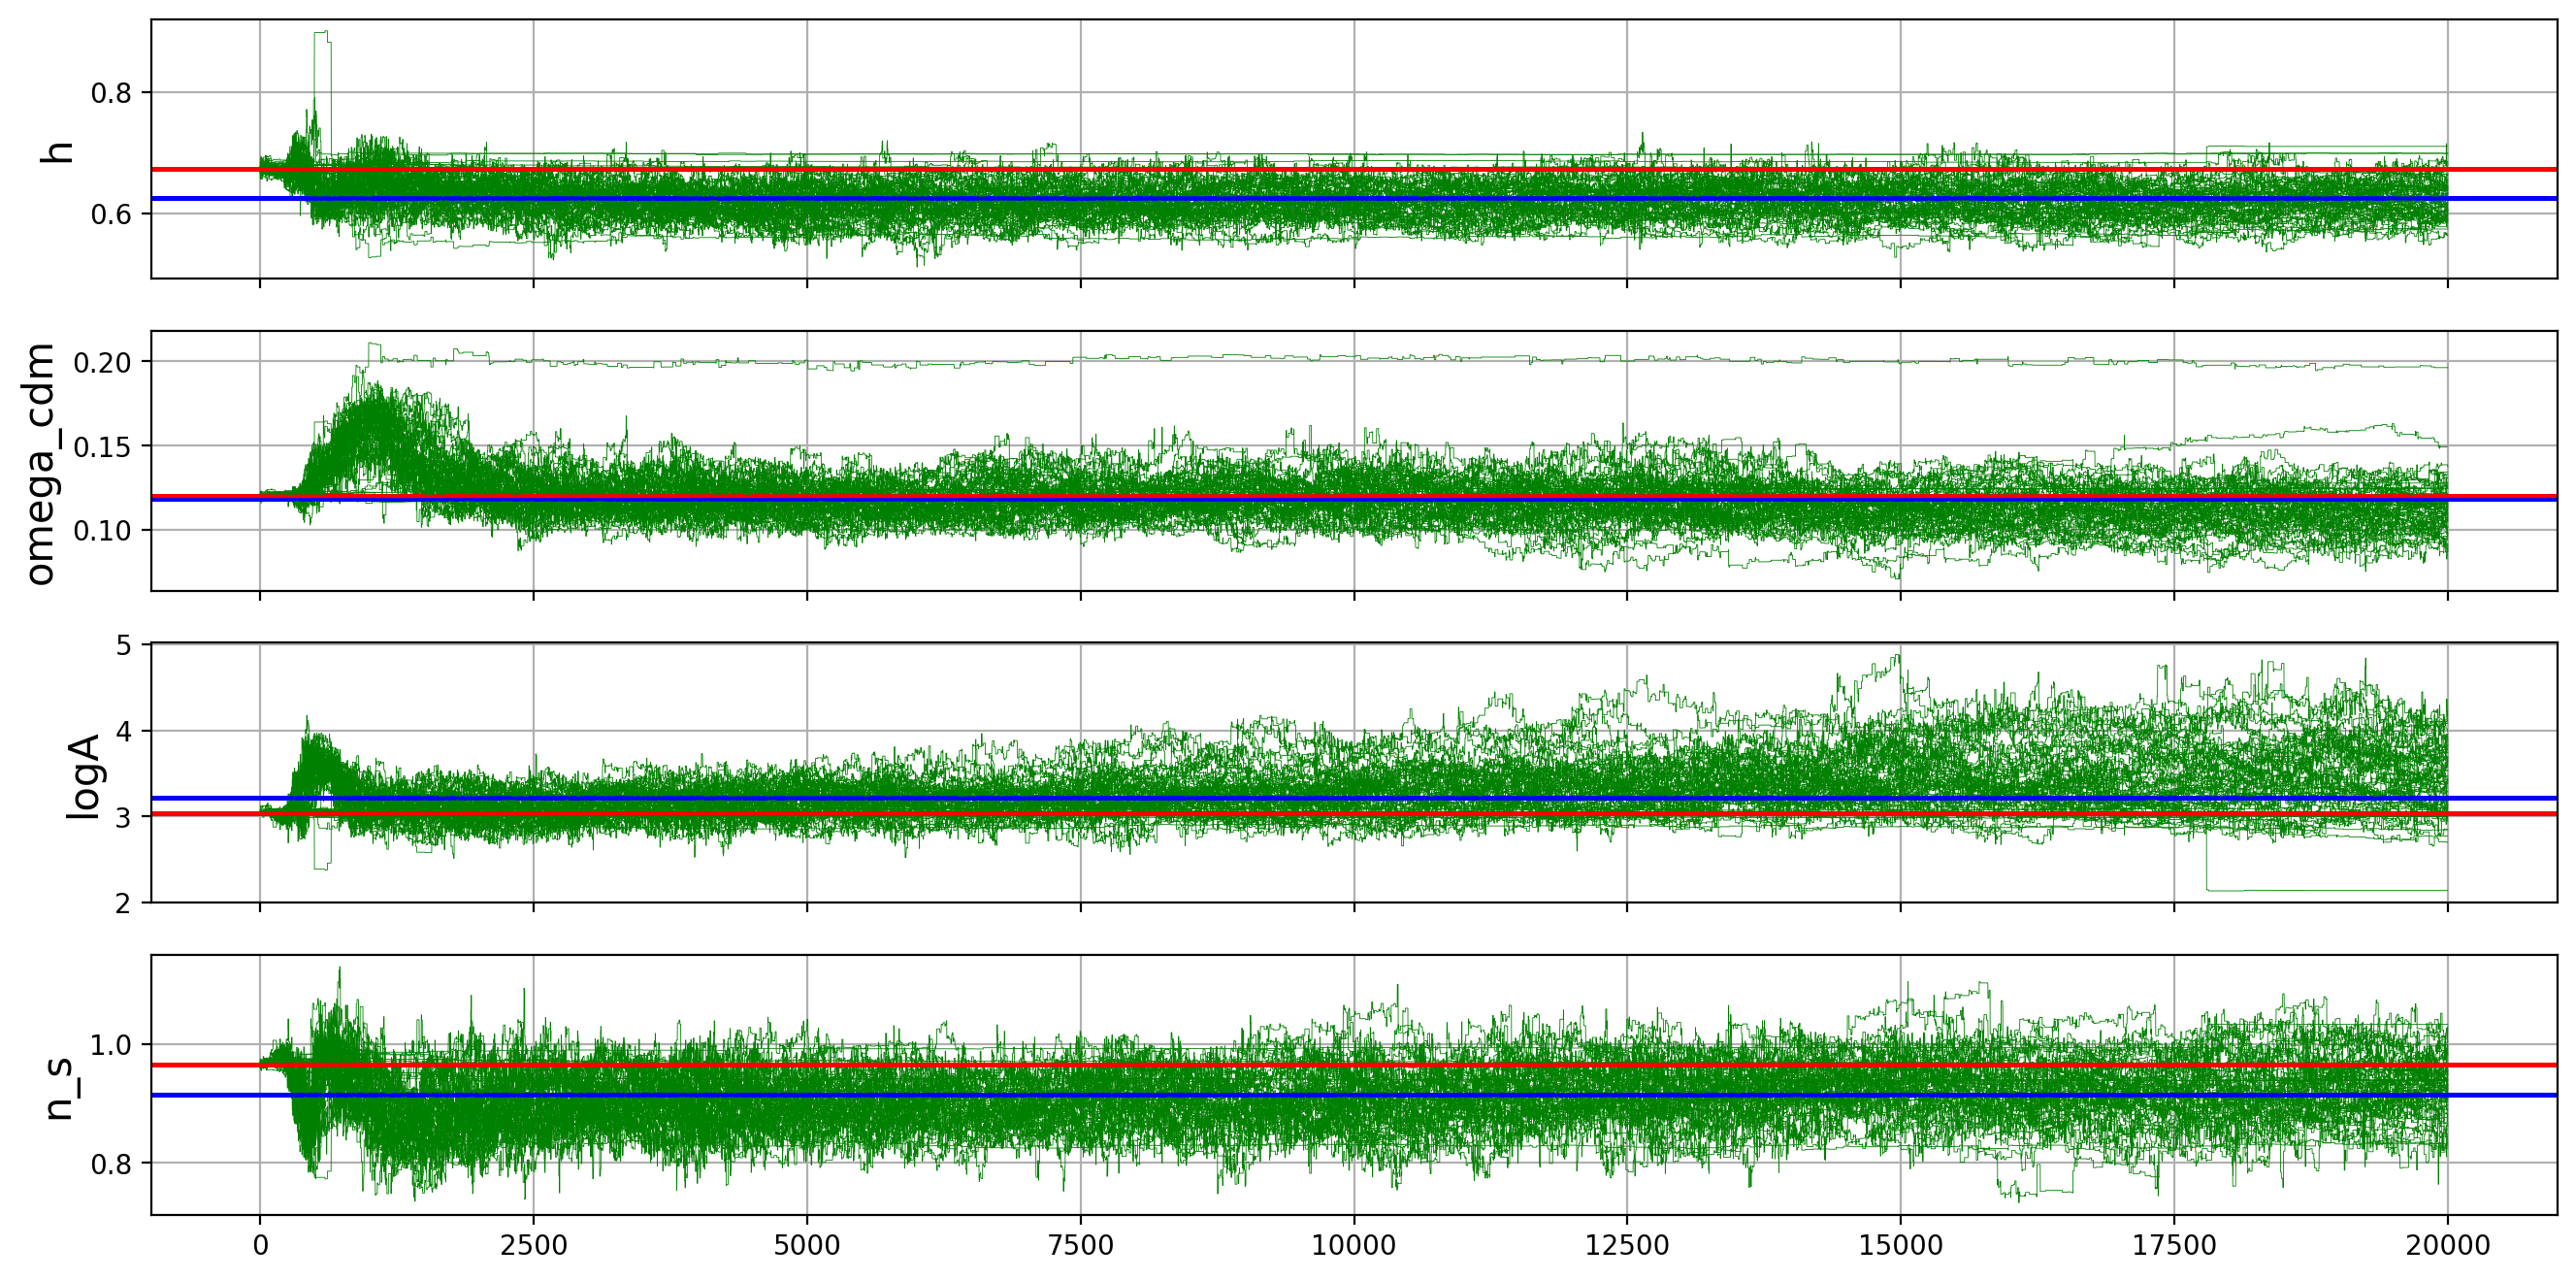

In [42]:
from plotting_tools import plot_observable, plot_mcmc_walkers, convert_chain
chain_fn = './test/chain.npy'
chain   = Chain.load(chain_fn)
# true_values = [PLANCK_COSMOLOGY[param] for param in params]
plot_mcmc_walkers(chain, params, nwalkers, true_values)

[003067.95] [0/1] 04-03 08:56  Chain                     INFO     Loading ./test/chain.npy.


chi2: 55.05480839990279
+-----------+---------+---------+---------+---------+-----------------+-----------------+
|           | argmax  |  mean   | median  |   std   | quantile:1sigma | interval:1sigma |
+-----------+---------+---------+---------+---------+-----------------+-----------------+
|     h     |  0.617  |  0.625  |  0.621  |  0.031  |  -0.029/+0.030  |  -0.033/+0.022  |
| omega_cdm |  0.119  |  0.118  |  0.117  |  0.016  |  -0.012/+0.011  | -0.0142/+0.0085 |
|  omega_b  | 0.02205 | 0.02215 | 0.02215 | 0.00051 | -5.2e-4/+5.3e-4 | -4.3e-4/+5.5e-4 |
|   logA    |  3.44   |  3.36   |  3.32   |  0.32   |   -0.30/+0.31   |   -0.37/+0.18   |
|    n_s    |  0.911  |  0.919  |  0.918  |  0.049  |  -0.051/+0.046  |  -0.046/+0.051  |
|    b1p    |  0.72   |  0.75   |  0.78   |  0.12   |  -0.074/+0.086  |  -0.061/+0.098  |
|    b2p    |  -1.06  |  -1.28  |  -1.32  |  0.39   |   -0.28/+0.17   |   -0.28/+0.17   |
|    bsp    |  2.01   |  1.87   |  1.99   |  0.70   |   -0.23/+0.55   |   -0

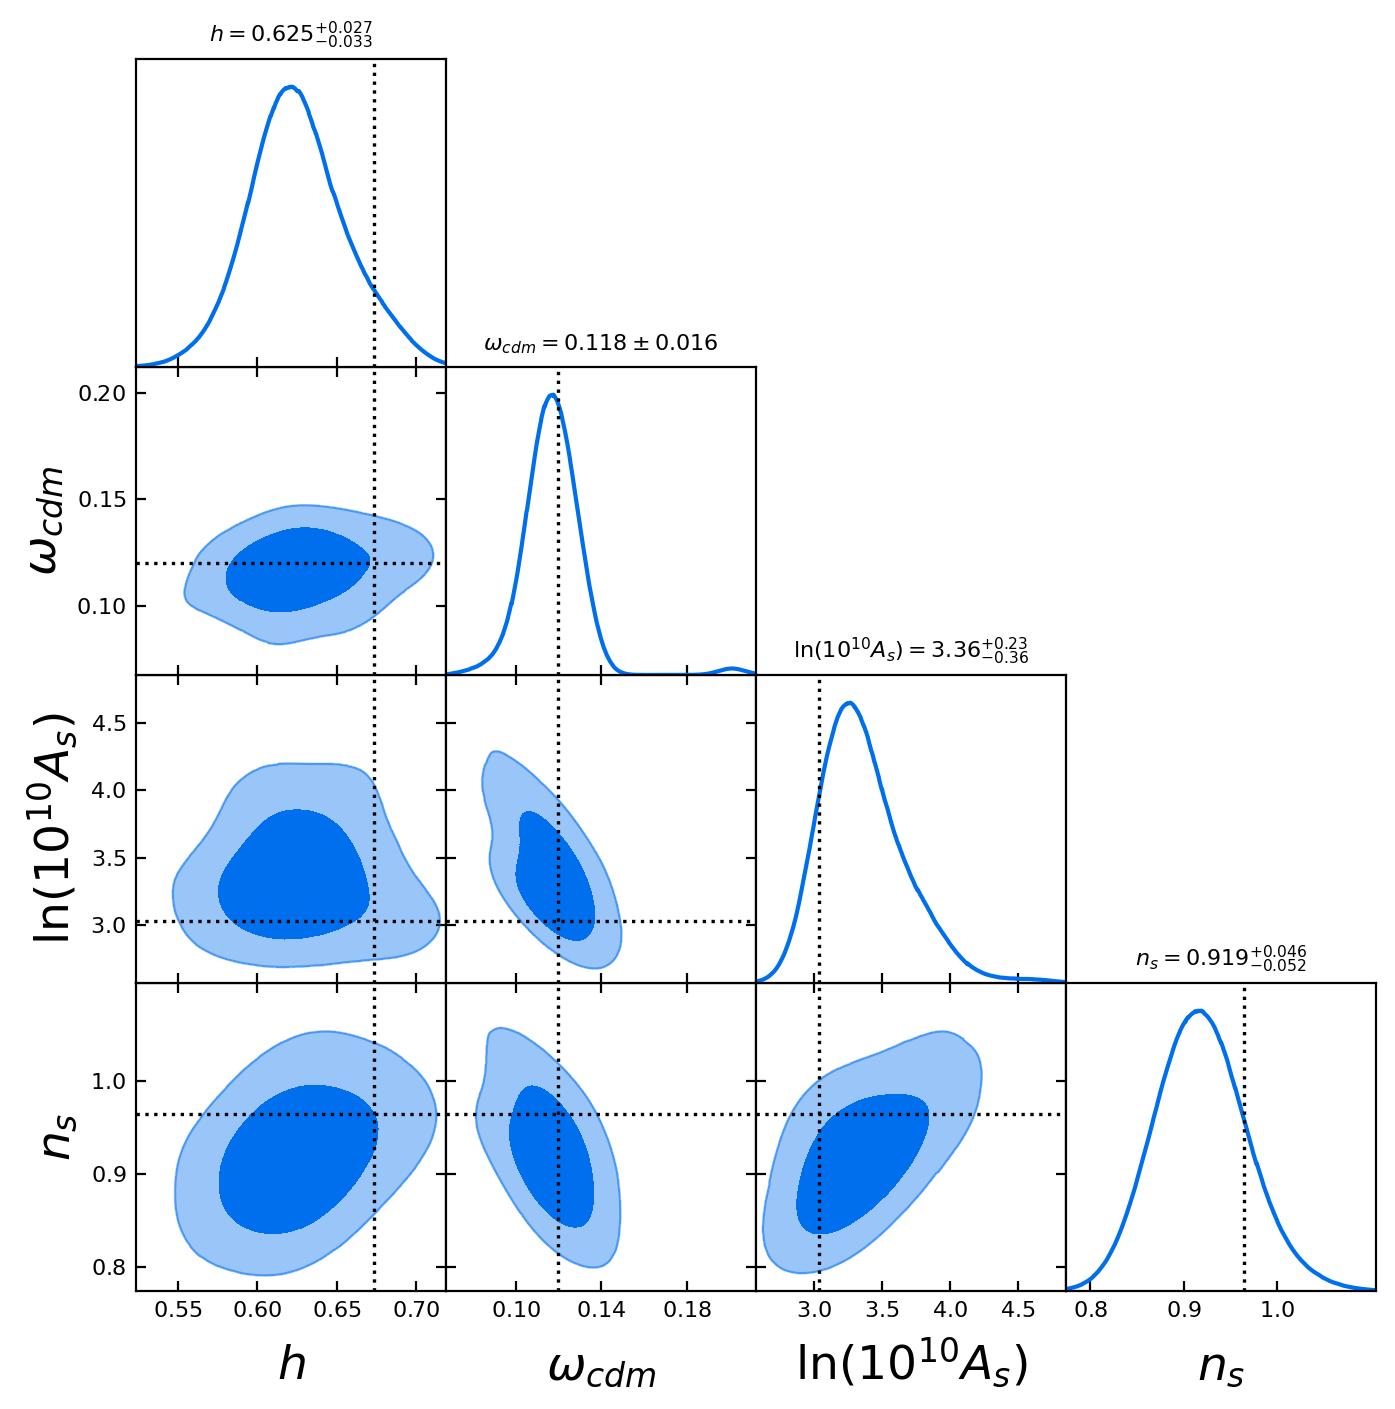

In [46]:
burnin = 0.5
slice_step = 5000
chain = Chain.load(chain_fn).remove_burnin(burnin)[::slice_step]
print('chi2:',-2*likelihood_el(**chain.choice(index='argmax', return_type='dict', input=True)))
print(chain.to_stats(tablefmt='pretty'))
g = plots.get_subplot_plotter()
g.settings.fig_width_inch= 8
g.settings.legend_fontsize = 20
g.settings.axes_labelsize = 20
g.settings.figure_legend_frame = False
plotting.plot_triangle(chain, title_limit=1, filled = True, params = params, contour_lws = 1.5,
                            smoothed=True, show=False, g=g)
def set_true_values(fit, params):
    if fit == 'SF':
        return [1,1,0,1]
    if fit == 'FM':
        return [PLANCK_COSMOLOGY[param] for param in params if param in PLANCK_COSMOLOGY]
true_values     = set_true_values(fit, params)
for i in range(len(true_values)):
    for j in range(i+1):
        g.subplots[i,j].axvline(true_values[j], c = 'k', ls = ':', lw = 1.2)
        if i != j:
            g.subplots[i,j].axhline(true_values[i], c = 'k', ls = ':', lw = 1.2)

In [88]:
fit = 'FM' # FM: Full-Modeling, SF: Shape-Fit
task = f'{fit}fit_cubic_sys'
theory_model = 'folps' # vel, folps

corr_type = 'pk'
bins_type = 'y3_sys'
(kmin, kmax, kbin, lenk) = load_bins(corr_type, bins_type)
klim = {ell*2: (kmin,kmax,kbin) for ell in range(2)}

for tracer in ['QSO']:
    (zmin, zmax) = Z_VSMEAR[tracer][0]
    z_eff = Z_CUBIC[tracer][0]
    data_args = {"tracer": tracer, "z_eff": z_eff, "zmin": zmin, "zmax": zmax, "sys_model": 'standard', "grid_cosmo": "000"}
    fit_args = {"corr_type": 'pk', "bins_type": 'y3_sys', "cov_type": 'EZcov_fn', "theory_model": theory_model, "option": 'fix_ns'}
    (_, _, theory) = get_observable_likelihood(task, data_args, fit_args)
    emulator_fn = result_dir+f'/emulator/fix_ns/emulator_{fit}_{tracer}_z{zmin}-{zmax}_{theory_model}.npy'
    if not os.path.exists(emulator_fn):
        print(data_args)
        emulator = Emulator(theory.pt, engine=TaylorEmulatorEngine(order=3, method='finite')) # Taylor expansion, up to a given order
        emulator.set_samples() # evaluate the theory derivatives (with jax auto-differentiation if possible, else finite differentiation)
        emulator.fit()
        emulator.save(emulator_fn)

Loading exist EZmocks covariance


/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/EZmocks/covariance/pk/cov_EZmocks_1.5Gpc_pk02_QSO_z0.8-2.1_k0.02-0.2.txt
[001554.09] [0/1] 04-01 08:00  TracerPowerSpectrumMultipolesObservable INFO     Loading 25 files [/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/QSO/obs_z0.8-2.1/AbacusSummit_base_c000_ph021/mpspk/pkpoles_QSO_z0.8-2.1_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/QSO/obs_z0.8-2.1/AbacusSummit_base_c000_ph017/mpspk/pkpoles_QSO_z0.8-2.1_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/QSO/obs_z0.8-2.1/AbacusSummit_base_c000_ph019/mpspk/pkpoles_QSO_z0.8-2.1_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/QSO/obs_z0.8-2.1/AbacusSummit_base_c000_ph020/mpspk/pkpoles_QSO_z0.8-2.1_standard.npy, ..., /pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/QSO/obs_z0.8-2.1/Abac

/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/desilike/base.py:445: UserWarning: Derived parameter sigma8 of <desilike.theories.galaxy_clustering.full_shape.FOLPSPowerSpectrumMultipoles object at 0x7ef83c0ccc10> is already derived in <desilike.theories.galaxy_clustering.power_template.DirectPowerSpectrumTemplate object at 0x7ef6dc189400>.
  if self.mpicomm.rank == 0: warnings.warn(msg)


[001561.75] [0/1] 04-01 08:00  Differentiation           INFO     Varied parameters: ['h', 'omega_cdm', 'omega_b', 'logA'].
[001564.47] [0/1] 04-01 08:00  Differentiation           INFO     h grid is [0.6136 0.6436 0.6736 0.7036 0.7336].
[001564.47] [0/1] 04-01 08:00  Differentiation           INFO     omega_cdm grid is [0.1  0.11 0.12 0.13 0.14].
[001564.47] [0/1] 04-01 08:00  Differentiation           INFO     omega_b grid is [0.01937 0.02087 0.02237 0.02387 0.02537].
[001564.47] [0/1] 04-01 08:00  Differentiation           INFO     logA grid is [2.89639426 2.96639426 3.03639426 3.10639426 3.17639426].
[001564.48] [0/1] 04-01 08:00  Differentiation           INFO     Differentiation will evaluate 73 points.
[001615.54] [0/1] 04-01 08:01  Emulator                  INFO     Fitting sigma8.
[001615.56] [0/1] 04-01 08:01  Emulator                  INFO     Fitting fsigma8.
[001615.58] [0/1] 04-01 08:01  Emulator                  INFO     Fitting kap.
[001615.60] [0/1] 04-01 08:01  Emulat